In [68]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [69]:
data_dir = '/content/drive/MyDrive/CAT_00'

In [70]:
!pip install git+https://github.com/openai/CLIP.git
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-95z0jlnd
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-95z0jlnd
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118


In [71]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import clip


In [72]:
class CatKeypointDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        self.img_files.sort()

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        cat_path = img_path + '.cat'

        image = Image.open(img_path).convert('RGB')
        w, h = image.size

        with open(cat_path, 'r') as f:
            line = f.readline().strip()
            parts = line.split()
            keypoints = list(map(float, parts[1:]))

        normalized_keypoints = []
        for i in range(0, len(keypoints), 2):
          x = keypoints[i]
          y = keypoints[i+1]
          x_new = x / w
          y_new = y / h
          normalized_keypoints.extend([x_new, y_new])

        normalized_keypoints = torch.tensor(normalized_keypoints).float()
        normalized_keypoints = torch.clamp(normalized_keypoints, min=0.0, max=1.0)

        if self.transform:
            image = self.transform(image)

        return image, normalized_keypoints


In [73]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

from torch.utils.data import random_split

full_dataset = CatKeypointDataset(img_dir=data_dir, transform=transform)

total_length = len(full_dataset)
train_length = int(total_length * 0.8)
val_length = total_length - train_length

train_dataset, val_dataset = random_split(full_dataset, [train_length, val_length])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [74]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [75]:
class KeypointRegressor(nn.Module):
    def __init__(self, input_dim=512, output_dim=18):
        super(KeypointRegressor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
    def forward(self, x):
        return self.fc(x)


clip_regressor = KeypointRegressor().to(device)


In [76]:
clip_criterion = nn.SmoothL1Loss();

clip_optimizer = optim.Adam(clip_regressor.parameters(), lr=5e-5, weight_decay=1e-4)

In [77]:
num_epochs = 30

clip_train_losses = []
clip_val_losses = []
for epoch in range(num_epochs):
    clip_regressor.train()
    total_loss = 0.0
    for images, keypoints in train_loader:
        images, keypoints = images.to(device), keypoints.to(device)
        with torch.no_grad():
            features = clip_model.encode_image(images)
            features = features.float()

        preds = clip_regressor(features)
        loss = clip_criterion(preds, keypoints)

        clip_optimizer.zero_grad()
        loss.backward()
        clip_optimizer.step()

        total_loss += loss.item() * images.size(0)
    avg_train_loss = total_loss / len(train_dataset)

    clip_regressor.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, keypoints in val_loader:
            images, keypoints = images.to(device), keypoints.to(device)
            features = clip_model.encode_image(images)
            features = features.float()
            preds = clip_regressor(features)
            loss = clip_criterion(preds, keypoints)
            val_loss += loss.item() * images.size(0)
    avg_val_loss = val_loss / len(val_dataset)

    clip_train_losses.append(avg_train_loss)
    clip_val_losses.append(avg_val_loss)

    print(f"[CLIP] Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


[CLIP] Epoch [1/30] Train Loss: 0.0610, Val Loss: 0.0281
[CLIP] Epoch [2/30] Train Loss: 0.0155, Val Loss: 0.0100
[CLIP] Epoch [3/30] Train Loss: 0.0099, Val Loss: 0.0096
[CLIP] Epoch [4/30] Train Loss: 0.0094, Val Loss: 0.0093
[CLIP] Epoch [5/30] Train Loss: 0.0091, Val Loss: 0.0092
[CLIP] Epoch [6/30] Train Loss: 0.0088, Val Loss: 0.0089
[CLIP] Epoch [7/30] Train Loss: 0.0086, Val Loss: 0.0088
[CLIP] Epoch [8/30] Train Loss: 0.0083, Val Loss: 0.0086
[CLIP] Epoch [9/30] Train Loss: 0.0082, Val Loss: 0.0086
[CLIP] Epoch [10/30] Train Loss: 0.0080, Val Loss: 0.0085
[CLIP] Epoch [11/30] Train Loss: 0.0079, Val Loss: 0.0083
[CLIP] Epoch [12/30] Train Loss: 0.0077, Val Loss: 0.0082
[CLIP] Epoch [13/30] Train Loss: 0.0076, Val Loss: 0.0082
[CLIP] Epoch [14/30] Train Loss: 0.0075, Val Loss: 0.0081
[CLIP] Epoch [15/30] Train Loss: 0.0074, Val Loss: 0.0080
[CLIP] Epoch [16/30] Train Loss: 0.0073, Val Loss: 0.0079
[CLIP] Epoch [17/30] Train Loss: 0.0072, Val Loss: 0.0080
[CLIP] Epoch [18/30] Tr

In [78]:
import torchvision.models as models

resnet = models.resnet18(pretrained=True)
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules).to(device)
resnet.eval()

class ResNetRegressor(nn.Module):
    def __init__(self, output_dim=18):
        super(ResNetRegressor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
    def forward(self, x):
        with torch.no_grad():
            feats = resnet(x)
        feats = feats.view(feats.size(0), -1)
        return self.fc(feats)

resnet_regressor = ResNetRegressor().to(device)
resnet_optimizer = optim.Adam(resnet_regressor.parameters(), lr=5e-5, weight_decay=1e-4)
resnet_criterion = nn.SmoothL1Loss();

resnet_train_losses = []
resnet_val_losses = []
num_epochs = 30
for epoch in range(num_epochs):
    resnet_regressor.train()
    total_loss = 0.0
    for images, keypoints in train_loader:
        images, keypoints = images.to(device), keypoints.to(device)

        preds = resnet_regressor(images)
        loss = resnet_criterion(preds, keypoints)

        resnet_optimizer.zero_grad()
        loss.backward()
        resnet_optimizer.step()

        total_loss += loss.item() * images.size(0)
    avg_train_loss = total_loss / len(train_dataset)

    resnet_regressor.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, keypoints in val_loader:
            images, keypoints = images.to(device), keypoints.to(device)
            preds = resnet_regressor(images)
            loss = resnet_criterion(preds, keypoints)
            val_loss += loss.item() * images.size(0)
    avg_val_loss = val_loss / len(val_dataset)

    resnet_train_losses.append(avg_train_loss)
    resnet_val_losses.append(avg_val_loss)

    print(f"[ResNet] Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


[ResNet] Epoch [1/30] Train Loss: 0.0515, Val Loss: 0.0174
[ResNet] Epoch [2/30] Train Loss: 0.0158, Val Loss: 0.0151
[ResNet] Epoch [3/30] Train Loss: 0.0142, Val Loss: 0.0138
[ResNet] Epoch [4/30] Train Loss: 0.0131, Val Loss: 0.0129
[ResNet] Epoch [5/30] Train Loss: 0.0122, Val Loss: 0.0123
[ResNet] Epoch [6/30] Train Loss: 0.0116, Val Loss: 0.0118
[ResNet] Epoch [7/30] Train Loss: 0.0110, Val Loss: 0.0114
[ResNet] Epoch [8/30] Train Loss: 0.0106, Val Loss: 0.0111
[ResNet] Epoch [9/30] Train Loss: 0.0103, Val Loss: 0.0108
[ResNet] Epoch [10/30] Train Loss: 0.0099, Val Loss: 0.0106
[ResNet] Epoch [11/30] Train Loss: 0.0096, Val Loss: 0.0104
[ResNet] Epoch [12/30] Train Loss: 0.0093, Val Loss: 0.0104
[ResNet] Epoch [13/30] Train Loss: 0.0091, Val Loss: 0.0100
[ResNet] Epoch [14/30] Train Loss: 0.0089, Val Loss: 0.0100
[ResNet] Epoch [15/30] Train Loss: 0.0087, Val Loss: 0.0099
[ResNet] Epoch [16/30] Train Loss: 0.0085, Val Loss: 0.0097
[ResNet] Epoch [17/30] Train Loss: 0.0083, Val Lo

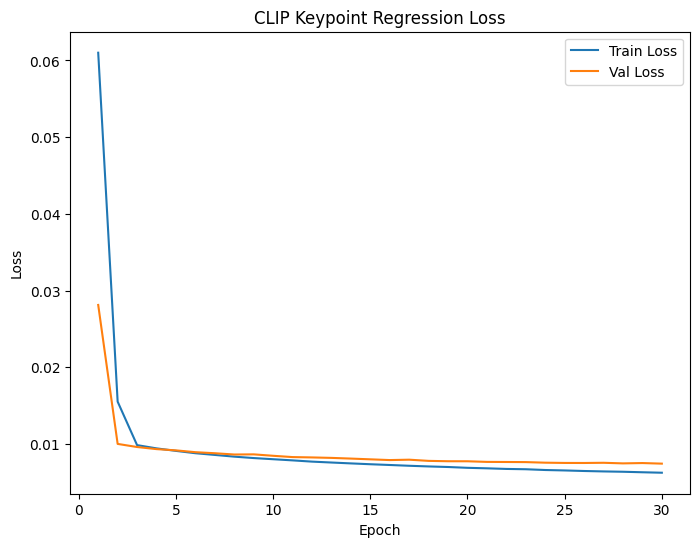

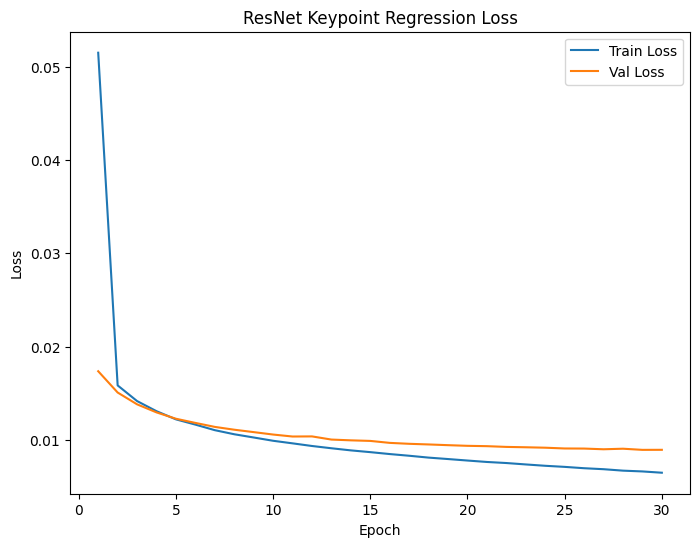

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), clip_train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), clip_val_losses, label='Val Loss')
plt.title("CLIP Keypoint Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), resnet_train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), resnet_val_losses, label='Val Loss')
plt.title("ResNet Keypoint Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

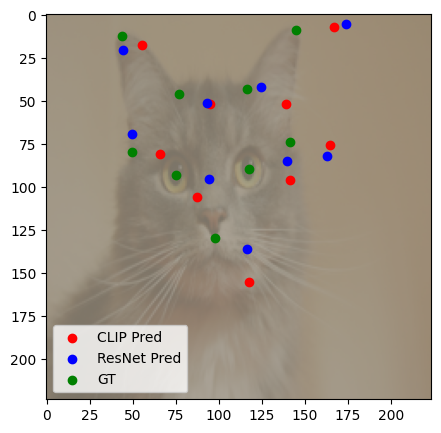

In [92]:
import matplotlib.pyplot as plt
images, keypoints = next(iter(val_loader))
images, keypoints = images.to(device), keypoints.to(device)

with torch.no_grad():
    clip_features = clip_model.encode_image(images)
    clip_features = clip_features.float()
    clip_preds = clip_regressor(clip_features)
clip_preds = clip_preds.cpu().numpy()

with torch.no_grad():
    resnet_preds = resnet_regressor(images)
resnet_preds = resnet_preds.cpu().numpy()

images = images.cpu().numpy()
keypoints = keypoints.cpu().numpy()

idx = 0
img = images[idx].transpose(1, 2, 0)
img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
img = img.clip(0,1)

clip_pred_keyps = clip_preds[idx].reshape(-1,2)
resnet_pred_keyps = resnet_preds[idx].reshape(-1,2)
gt_keyps = keypoints[idx].reshape(-1,2)

height, width, _ = img.shape
clip_pred_keyps_scaled = clip_pred_keyps * [width, height]
resnet_pred_keyps_scaled = resnet_pred_keyps * [width, height]
gt_keyps_scaled = gt_keyps * [width, height]

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.scatter(clip_pred_keyps_scaled[:,0], clip_pred_keyps_scaled[:,1], c='r', label='CLIP Pred')
plt.scatter(resnet_pred_keyps_scaled[:,0], resnet_pred_keyps_scaled[:,1], c='b', label='ResNet Pred')
plt.scatter(gt_keyps_scaled[:,0], gt_keyps_scaled[:,1], c='g', label='GT')
plt.legend()
plt.show()

In [81]:
test_dir = '/content/drive/MyDrive/CAT_01'

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

class CatKeypointDatasetTest(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        self.img_files.sort()

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        cat_path = img_path + '.cat'

        image = Image.open(img_path).convert('RGB')
        w, h = image.size

        with open(cat_path, 'r') as f:
            line = f.readline().strip()
            parts = line.split()
            keypoints = list(map(float, parts[1:]))

        normalized_keypoints = []
        for i in range(0, len(keypoints), 2):
            x = keypoints[i] / w
            y = keypoints[i+1] / h
            normalized_keypoints.extend([x, y])
        normalized_keypoints = torch.tensor(normalized_keypoints).float()
        normalized_keypoints = torch.clamp(normalized_keypoints, min=0.0, max=1.0)

        if self.transform:
            image = self.transform(image)

        return image, normalized_keypoints

test_dataset = CatKeypointDatasetTest(img_dir=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def evaluate_model(model, loader, criterion, device, backbone="CLIP"):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, keypoints in loader:
            images, keypoints = images.to(device), keypoints.to(device)
            if backbone == "CLIP":
                features = clip_model.encode_image(images).float()
                preds = model(features)
            else:
                preds = model(images)

            loss = criterion(preds, keypoints)
            total_loss += loss.item() * images.size(0)
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss

clip_test_loss = evaluate_model(clip_regressor, test_loader, clip_criterion, device, backbone="CLIP")
print(f"[CLIP Test] Average Loss: {clip_test_loss:.4f}")

resnet_test_loss = evaluate_model(resnet_regressor, test_loader, resnet_criterion, device, backbone="ResNet")
print(f"[ResNet Test] Average Loss: {resnet_test_loss:.4f}")


[CLIP Test] Average Loss: 0.0083
[ResNet Test] Average Loss: 0.0098
